# Gender classification from tweets content

# Idea </br>
- Extract different feature from the text: </br> 
- Preprocessing
    + hastag, url, mention
    + clean HTLM
- Featues:
    + Content features: TF-IDF, Bag of Words
- Classificaton approach: 
    + Logistic regression
    + Random Forest
    + SVC
    + ~LightBGM~

In [1]:
!pip install stopwords
!pip install pyspellchecker
!pip install SpellChecker
!pip install wordnet
!pip install wordcloud
!pip install termcolor
!pip install nltk

In [2]:
import os, pandas as pd, numpy as np
import re
from bs4 import BeautifulSoup
import nltk
from nltk.text import Text
from nltk.tokenize import word_tokenize,WhitespaceTokenizer,TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from spellchecker import SpellChecker
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\root\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\root\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\root\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 1. Acquire data

In [4]:
DATASET_PATH = './dataset/english/'
LABELS = ['userid', 'gender', 'age_group', 'extroverted', 'stable', 'agreeable', 'conscientious', 'open']

In [5]:
# extract content from XML format
def ExtractTweets(xml):
    """
    This function extracts each tweet from Twitter Timeline given in XML
    """
    bs_content = BeautifulSoup(xml, 'xml')
    return [doc.text.strip() for doc in bs_content.find_all("document")]

In [6]:
# Author Labels
user_details = []
for labels in open(os.path.join(DATASET_PATH, 'truth.txt'), 'r'):
    user_details.append(list(map(str.strip, labels.split(':::'))))
    
user_df = pd.DataFrame(data=user_details, columns=LABELS)
user_df['userid'] = user_df['userid'].apply(str)
user_df['gender'] = user_df['gender'].apply(str)
user_df['age_group'] = user_df['age_group'].apply(str)
user_df['extroverted'] = user_df['extroverted'].apply(float)
user_df['stable'] = user_df['stable'].apply(float)
user_df['agreeable'] = user_df['agreeable'].apply(float)
user_df['conscientious'] = user_df['conscientious'].apply(float)
user_df['open'] = user_df['open'].apply(float)
user_df

,userid,gender,age_group,extroverted,stable,agreeable,conscientious,open
0,user552,M,25-34,0.3,0.5,0.1,0.2,0.2
1,user865,M,25-34,0.2,0.4,0.2,0.0,0.2
2,user103,M,18-24,0.1,0.2,0.1,0.1,0.1
3,user179,F,18-24,0.1,0.1,-0.1,0.5,0.1
4,user321,F,18-24,0.0,-0.1,0.1,0.3,0.4
...,...,...,...,...,...,...,...,...
147,user709,M,25-34,0.2,0.2,0.1,0.1,0.5
148,user931,F,18-24,0.5,0.3,0.0,0.1,0.3
149,user96,F,25-34,0.4,-0.3,0.0,0.1,0.3
150,user551,M,25-34,0.3,0.5,0.1,0.2,0.2


In [7]:
# Author Tweets
data = []
user_xmls = list(filter(lambda file: file != 'truth.txt', os.listdir(DATASET_PATH)))
for xml_filename in user_xmls:
    userid = os.path.splitext(xml_filename)[0]
    path = os.path.join(DATASET_PATH, xml_filename)
    with open(path, 'r', encoding='utf-8') as timeline:
        tweets = ExtractTweets(timeline)
    data.append([userid, tweets])
data = pd.DataFrame(data=data, columns=['userid', 'tweets'])
data

,userid,tweets
0,user1,"[""Fun is the enjoyment of pleasure"", @username..."
1,user1007,[I just became the mayor of Porta Romana on @u...
2,user103,[@username @username @username @username #IfM...
3,user104,[What You're Saying With Your Facial Hair http...
4,user112,"[@username sactan ne haber?, Aurora borealis i..."
...,...,...
147,user96,[Nasa to turn ISS into perfect Earth-observing...
148,user97,[A tour of the International Space Station - h...
149,user973,"[@username @username ay friend, q te fumasteSS..."
150,user989,[-2 to help save tha interwebs: http://t.co/Kf...


In [8]:
user_df = user_df.sort_values(by = 'userid', ascending = True)
data = data.sort_values(by = 'userid', ascending = True)

In [9]:
user_df.head()

,userid,gender,age_group,extroverted,stable,agreeable,conscientious,open
57,user1,M,50-XX,0.4,0.3,0.5,0.2,0.3
144,user1007,F,25-34,0.5,0.1,0.1,0.1,0.1
2,user103,M,18-24,0.1,0.2,0.1,0.1,0.1
58,user104,M,18-24,0.1,0.2,0.1,0.1,0.1
74,user112,F,18-24,-0.1,0.3,0.2,0.0,0.3


In [10]:
data.head()

,userid,tweets
0,user1,"[""Fun is the enjoyment of pleasure"", @username..."
1,user1007,[I just became the mayor of Porta Romana on @u...
2,user103,[@username @username @username @username #IfM...
3,user104,[What You're Saying With Your Facial Hair http...
4,user112,"[@username sactan ne haber?, Aurora borealis i..."


## 2. Text Preprocessing


In [11]:
def tokenize(method, text):
    if method == 'word_tokenize':
        return word_tokenize(text)
    if method == 'tweet_tokenize':
        return TweetTokenizer(text)

In [12]:
def stop_words_remover(example_sent):
    st_words_lst=set(stopwords.words('english'))
    st_words_lst.add('via')
    tk = WhitespaceTokenizer()
    word_tokens = tk.tokenize(example_sent)
    #print(word_tokens)
    filtered_sentence = [w for w in word_tokens if w.lower() not in st_words_lst]
    #print(filtered_sentence)
    print("Removed:\t", len(word_tokens) - len(filtered_sentence), 'words from\t', len(word_tokens), 'words')
    filtered_sentence=" ".join(filtered_sentence)
    return filtered_sentence

In [13]:
def Lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [14]:
def removeURL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [15]:
def removeHTMLTag(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [16]:
def correctSpelling(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
            print('Corrected\t', word, "\t to \t", corrected_text[-1])
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "#IfMyNameWas @username i'd catch ol #pokemon n hv won all b"
correctSpelling(text)

Corrected	 @username 	 to 	 username
Corrected	 #pokemon 	 to 	 pokemon
Corrected	 n 	 to 	 i
Corrected	 hv 	 to 	 he
Corrected	 b 	 to 	 i


"#IfMyNameWas username i'd catch ol pokemon i he won all i"

In [17]:
def numberOfPosts(text):
    return len(text)

In [18]:
def numberOfTags(text):
    return text.count('@')

In [19]:
def numberOfHastags(text):
    return text.count('#')

In [20]:
def dropUseless(text):
    return text.replace('@username', '').replace('.', '').replace('/', '').replace('-', '').replace('>', '').replace('<', '').replace(':', '').replace(';', '').replace(
    ')', '').replace('(', '').replace('+', '').replace('=', '').replace('\\', '').replace('"', '').replace('&', '').replace('!', '').replace('*', '')


In [21]:
def encodeLabel(label):
    if label == 'M':
        return 0
    if label == 'F':
        return 1

#### Create a column named numberOfPosts, in case using later

In [22]:
data['numberOfPosts'] = data['tweets'].apply(lambda text: numberOfPosts(text))
data.head()

,userid,tweets,numberOfPosts
0,user1,"[""Fun is the enjoyment of pleasure"", @username...",95
1,user1007,[I just became the mayor of Porta Romana on @u...,100
2,user103,[@username @username @username @username #IfM...,100
3,user104,[What You're Saying With Your Facial Hair http...,100
4,user112,"[@username sactan ne haber?, Aurora borealis i...",100


#### Merge diffent tweets of a user to a single string in _tweets_ column

In [23]:
twdata = []
for tweet in data['tweets']:
    tweet = list(tweet)
    tweet = ' '.join(tweet)
    twdata.append(tweet)
cdata = {'user': np.array(data['userid']), 'tweets': np.array(twdata), 'gender': np.array(user_df['gender']), 'numberOfPosts': np.array(data['numberOfPosts'])}
cdata = pd.DataFrame(cdata)
cdata.head()

,user,tweets,gender,numberOfPosts
0,user1,"""Fun is the enjoyment of pleasure"" @username d...",M,95
1,user1007,I just became the mayor of Porta Romana on @us...,F,100
2,user103,@username @username @username @username #IfMy...,M,100
3,user104,What You're Saying With Your Facial Hair http:...,M,100
4,user112,@username sactan ne haber? Aurora borealis ici...,F,100


#### Remove stop words, which do not have specific meaning

In [24]:
cdata["tweets"] = cdata["tweets"].apply(lambda text: stop_words_remover(text))
# for tw in cdata['tweets']:
#     tw = stop_words_remover(tw)

Removed:	 328 words from	 1217 words
Removed:	 291 words from	 1083 words
Removed:	 508 words from	 1542 words
Removed:	 390 words from	 1214 words
Removed:	 263 words from	 1172 words
Removed:	 245 words from	 1029 words
Removed:	 679 words from	 1597 words
Removed:	 629 words from	 1868 words
Removed:	 676 words from	 1663 words
Removed:	 786 words from	 1775 words
Removed:	 586 words from	 1791 words
Removed:	 619 words from	 1758 words
Removed:	 252 words from	 982 words
Removed:	 359 words from	 1078 words
Removed:	 92 words from	 360 words
Removed:	 270 words from	 838 words
Removed:	 406 words from	 1004 words
Removed:	 454 words from	 1375 words
Removed:	 438 words from	 1310 words
Removed:	 381 words from	 981 words
Removed:	 339 words from	 998 words
Removed:	 230 words from	 828 words
Removed:	 105 words from	 411 words
Removed:	 199 words from	 1174 words
Removed:	 156 words from	 1156 words
Removed:	 187 words from	 1052 words
Removed:	 284 words from	 914 words
Removed:	 

#### Remove URL

In [25]:
cdata['tweets'] = cdata['tweets'].apply(lambda text: removeURL(text))

#### Remove HTML Tag

In [26]:
cdata['tweets'] = cdata['tweets'].apply(lambda text: removeHTMLTag(text))

#### Create another column called numberOfTags counting the number of mention other users per post => may use later

In [27]:
numTag = np.array(cdata['tweets'].apply(lambda text: numberOfTags(text)))
numPosts = np.array(cdata['numberOfPosts'])
numTag = np.divide(numTag, numPosts)
cdata['numberOfTags'] = numTag
cdata.head()

,user,tweets,gender,numberOfPosts,numberOfTags
0,user1,"""Fun enjoyment pleasure"" @username det fanns e...",M,95,0.821053
1,user1007,became mayor Porta Romana @username! became m...,F,100,0.760000
2,user103,@username @username @username @username #IfMyN...,M,100,1.330000
3,user104,Saying Facial Hair @username @username south ...,M,100,0.580000
4,user112,@username sactan ne haber? Aurora borealis ici...,F,100,0.330000


#### Calculate numberOfHastags per post

In [28]:
numHastag = np.array(cdata['tweets'].apply(lambda text: numberOfHastags(text)))
numPosts = np.array(cdata['numberOfPosts'])
numHastag = np.divide(numHastag, numPosts)
cdata['numberOfHastags'] = numHastag
cdata.head()

,user,tweets,gender,numberOfPosts,numberOfTags,numberOfHastags
0,user1,"""Fun enjoyment pleasure"" @username det fanns e...",M,95,0.821053,0.189474
1,user1007,became mayor Porta Romana @username! became m...,F,100,0.760000,0.230000
2,user103,@username @username @username @username #IfMyN...,M,100,1.330000,0.500000
3,user104,Saying Facial Hair @username @username south ...,M,100,0.580000,0.500000
4,user112,@username sactan ne haber? Aurora borealis ici...,F,100,0.330000,0.340000


#### Drop some special characters and the keyword 'username', as it is used to represent a person being tagged

In [29]:
cdata['tweets'] = cdata['tweets'].apply(lambda text: dropUseless(text))

#### Lematize the text

In [30]:
cdata['tweets'] = cdata['tweets'].apply(lambda text: Lemmatizer(text))

#### Correct Spelling - won't use as it's very time consuming

In [31]:
# cdata['tweets'] = cdata['tweets'].apply(lambda text: correctSpelling(text))

#### Encode label to 0 and 1

In [32]:
cdata['gender'] = cdata['gender'].apply(lambda gender: encodeLabel(gender))

In [33]:
cdata.head()

,user,tweets,gender,numberOfPosts,numberOfTags,numberOfHastags
0,user1,Fun enjoyment pleasure det fanns ett utvik med...,0,95,0.821053,0.189474
1,user1007,become mayor Porta Romana become mayor Torino ...,1,100,0.760000,0.230000
2,user103,#IfMyNameWas YashChopra i'd name lead Abhinav ...,0,100,1.330000,0.500000
3,user104,Saying Facial Hair south Indian speak punjabi ...,0,100,0.580000,0.500000
4,user112,sactan ne haber? Aurora borealis icin yasiyoru...,1,100,0.330000,0.340000


In [34]:
cdata.iloc[0].tweets

"Fun enjoyment pleasure det fanns ett utvik med sabrina without stitch acke nothing precis gladly crosseyed bear och så heter de med liksom barnramsetitlar first tweet hear abdur give talk reveals yrvaken adopter rädsla komma efter ? feedback? woman want dance floor forskare har kul med avatarer pain chocolate DOUGHBOY The Unwisdom Crowds?? peoplepowered revolution overrate Nonsensical junk opinion piece big data ny time ahoy, need statement estland ftw Stillsuits here KTHHVR #fremen Commation first casualty riot brother experience conceptual modeller translate ERD back forth tofrom txt stay pretty stable altho b fair talk think motivate here's set entities, let's explain them graph begin w really data, character data Describe data, share it #ecir2014 keep share data set train cannot land overtraining parameter fiddle #ecir2014 original reason share data much convenience reproducibility #ecir2014 true, that's can corpus, precisely like stream result form on one month Portuguese tweet g

In [35]:
# cdata['tweets'] = cdata['tweets'].apply(lambda text: correctSpelling(text))

In [36]:
# data.iloc[0].tweets

# 2. Exploratory Analysis

In [37]:
import warnings   
from wordcloud import WordCloud
from termcolor import cprint

<AxesSubplot:xlabel='numberOfTags', ylabel='gender'>

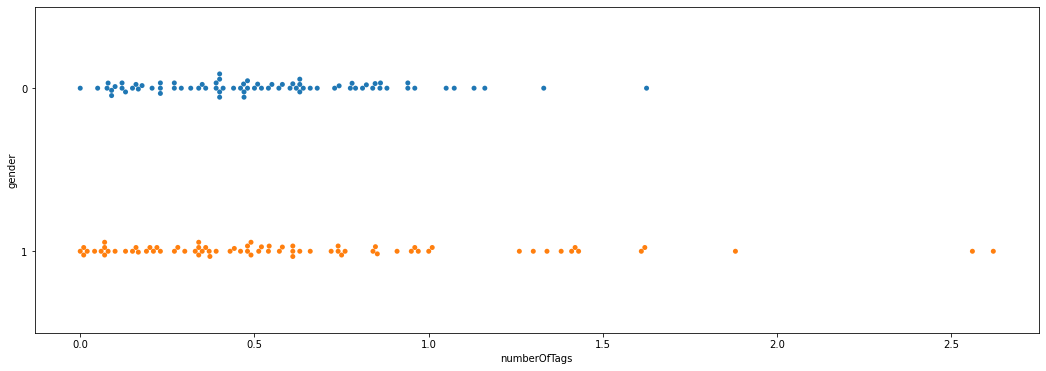

In [38]:
DF = pd.concat([cdata['numberOfTags'], cdata['gender']], axis = 1).reindex(cdata['gender'].index)

f = plt.figure(figsize=(18, 6))
sns.swarmplot(x = "numberOfTags", y = "gender", data = DF, orient = "h")

<AxesSubplot:xlabel='numberOfHastags', ylabel='gender'>

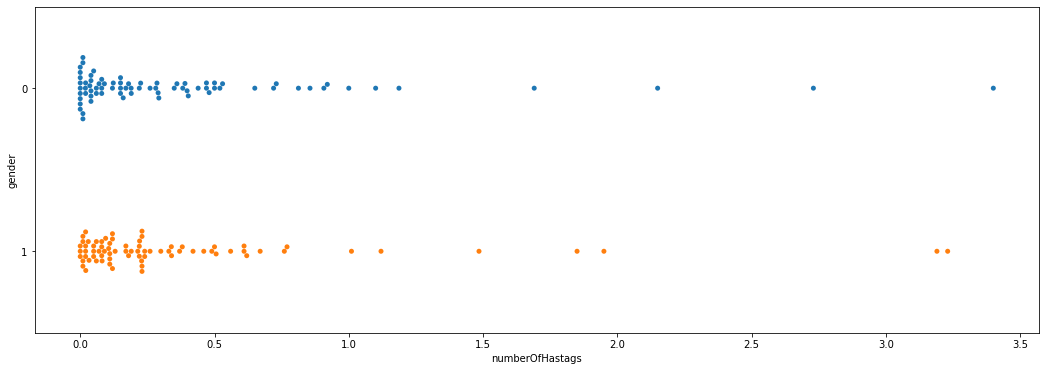

In [39]:
DF = pd.concat([cdata['numberOfHastags'], cdata['gender']], axis = 1).reindex(cdata['gender'].index)

f = plt.figure(figsize=(18, 6))
sns.swarmplot(x = "numberOfHastags", y = "gender", data = DF, orient = "h")

we can see, the distriution is not very different. Therefore, I would not use these 2 variables as predictors

#### Wordcloud, visualize the most frequent words in each class (male and female)

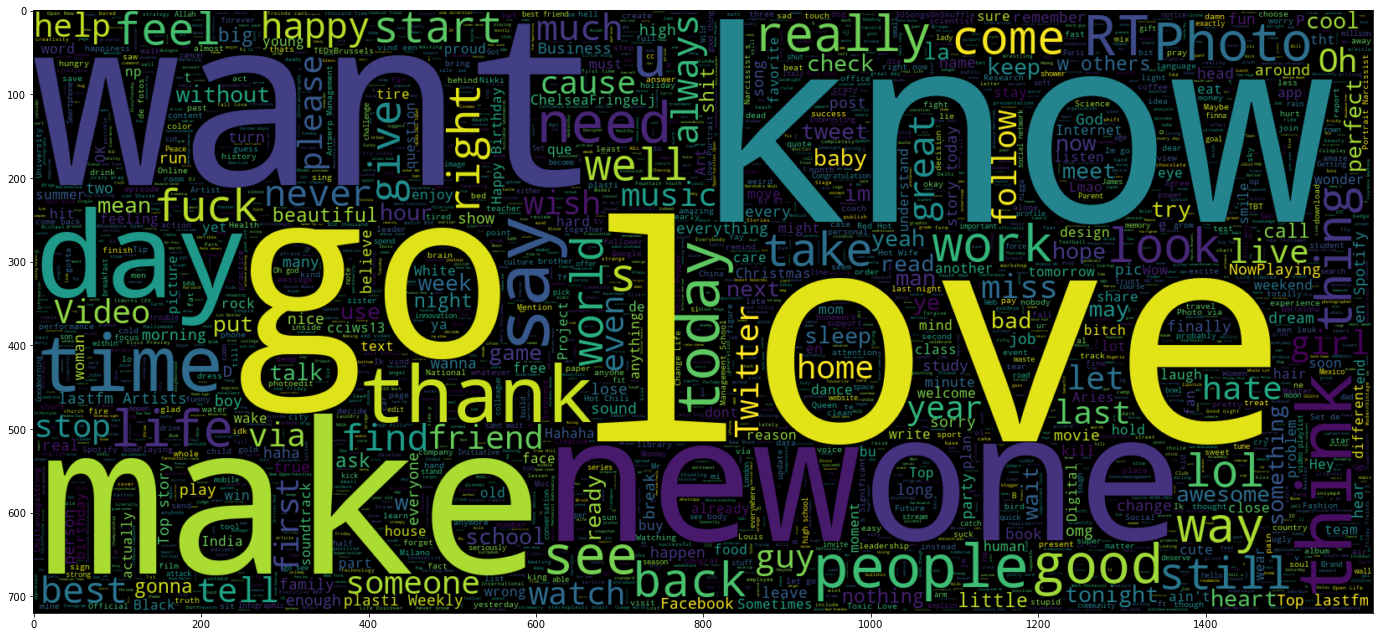

In [40]:
female = cdata[cdata['gender']==1].tweets
male = cdata[cdata['gender']==0].tweets

plt.figure(figsize=(24,20))

world_cloud_female = WordCloud(min_font_size=3,max_words=3200,width=1600,height=720).generate("".join(female))
plt.imshow(world_cloud_female, interpolation='bilinear')


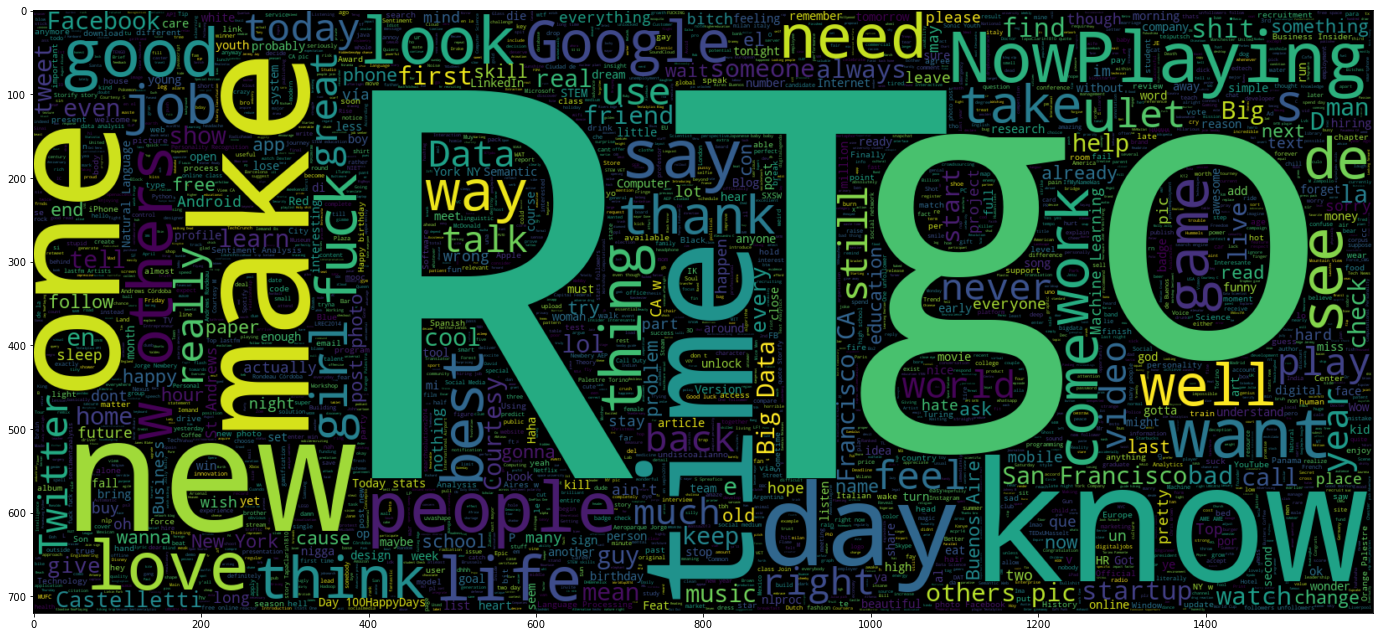

In [41]:
plt.figure(figsize=(24,20))

world_cloud_male = WordCloud(min_font_size=3,max_words=3200,width=1600,height=720).generate("".join(male))
plt.imshow(world_cloud_male, interpolation='bilinear')


# 3. Embedding with TF-IDF

In [42]:
predictor = ['tweets']
target = 'gender'
X = cdata[predictor]
y = cdata[target]

In [43]:
tf_idfvec = TfidfVectorizer(decode_error=True,use_idf=True,lowercase=True,min_df=2)
X = tf_idfvec.fit_transform(X.tweets.values.astype('U'))    
#test_tfidf=TfidfVectorizer(decode_error=True,use_idf=True,lowercase=True,min_df=2)
# X_test = tf_idfvec.transform(X_test.tweets.values.astype('U'))
print(X.shape)


(152, 6393)


# 4. Machine Learning Model with TF-IDF embedding

In [44]:
def report(y_train, y_train_pred, y_test, y_test_pred):
    print('=======CLASSIFICATION REPORT=======')
    print("On the training set")
    print(classification_report(y_train, y_train_pred))
    print('+ Accuracy score: ', accuracy_score(y_train, y_train_pred))
    print('+ ROC AUC Score: ', roc_auc_score(y_train, y_train_pred))
    print('+ confusion matrix')
    print(confusion_matrix(y_train, y_train_pred))
    print()
    print("On the test set")
    print(classification_report(y_test, y_test_pred))
    print('+ Accuracy score: ', accuracy_score(y_test, y_test_pred))
    print('+ ROC AUC Score: ', roc_auc_score(y_test, y_test_pred))
    print('+ confusion matrix')
    print(confusion_matrix(y_test, y_test_pred))
    print('====================================')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(121, 6393)
(31, 6393)
(121,)
(31,)


#### Logistic Regression

In [46]:
model=LogisticRegression(C = 100)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

=======CLASSIFICATION REPORT=======
On the training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        57

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

+ Accuracy score:  1.0
+ ROC AUC Score:  1.0
+ confusion matrix
[[64  0]
 [ 0 57]]

On the test set
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.93      0.74      0.82        19

    accuracy                           0.81        31
   macro avg       0.81      0.83      0.80        31
weighted avg       0.84      0.81      0.81        31

+ Accuracy score:  0.8064516129032258
+ ROC AUC Score:  0.8267543859649122
+ confusion matrix
[[11  1]
 [ 5 14]]


#### Random Forest

In [47]:
rf_model = RandomForestClassifier(max_depth = 5, random_state=0)
rf_model.fit(X_train,y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

=======CLASSIFICATION REPORT=======
On the training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        57

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

+ Accuracy score:  1.0
+ ROC AUC Score:  1.0
+ confusion matrix
[[64  0]
 [ 0 57]]

On the test set
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.81      0.68      0.74        19

    accuracy                           0.71        31
   macro avg       0.71      0.72      0.70        31
weighted avg       0.73      0.71      0.71        31

+ Accuracy score:  0.7096774193548387
+ ROC AUC Score:  0.7171052631578947
+ confusion matrix
[[ 9  3]
 [ 6 13]]


#### Support Vector Machine

In [48]:
linear_svc = SVC(kernel='linear', C=10) 
linear_svc.fit(X_train,y_train) 
y_train_pred = linear_svc.predict(X_train)
y_test_pred = linear_svc.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

=======CLASSIFICATION REPORT=======
On the training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        57

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

+ Accuracy score:  1.0
+ ROC AUC Score:  1.0
+ confusion matrix
[[64  0]
 [ 0 57]]

On the test set
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.93      0.74      0.82        19

    accuracy                           0.81        31
   macro avg       0.81      0.83      0.80        31
weighted avg       0.84      0.81      0.81        31

+ Accuracy score:  0.8064516129032258
+ ROC AUC Score:  0.8267543859649122
+ confusion matrix
[[11  1]
 [ 5 14]]


In [49]:
# params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
#               'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
#               'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
#               'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
#               'min_split_gain': 0.5, 'min_child_weight': 1, 
#               'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
#               'metric': 'binary_error', 'random_state': 0}
# grid_params = {'learning_rate': [0.01], 'n_estimators': [8, 24],
#                    'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
#                    'objective': ['binary'], 'seed': [500],
#                    'colsample_bytree': [0.65, 0.75, 0.8], 
#                    'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
#                    'reg_lambda': [1, 2, 6]}
# model = lgb.LGBMClassifier(**params)
# grid = GridSearchCV(model, param_grid=grid_params, verbose=5, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train)

# best_params = {k: grid.best_params_.get(k, v) for k, v in params.items()}
# best_params['verbosity'] = -1
# best_params['random_state'] = 0

In [50]:
# lgb_model = lgb.LGBMClassifier(**best_params)
# lgb_model.fit(X_train, y_train)
# y_train_pred = lgb_model.predict(X_train)
# y_test_pred = lgb_model.predict(X_test)
# report(y_train, y_train_pred, y_test, y_test_pred)

# CountVectorizer

In [51]:
predictor = ['tweets']
target = 'gender'
X2 = cdata[predictor]
y2 = cdata[target]

In [52]:
count_vectorizer = CountVectorizer(max_features=7000,stop_words = "english")
X2 = count_vectorizer.fit_transform(cdata['tweets']).toarray()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0, shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(121, 7000)
(31, 7000)
(121,)
(31,)


In [54]:
model=LogisticRegression(C = 100)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

=======CLASSIFICATION REPORT=======
On the training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        57

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

+ Accuracy score:  1.0
+ ROC AUC Score:  1.0
+ confusion matrix
[[64  0]
 [ 0 57]]

On the test set
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.93      0.74      0.82        19

    accuracy                           0.81        31
   macro avg       0.81      0.83      0.80        31
weighted avg       0.84      0.81      0.81        31

+ Accuracy score:  0.8064516129032258
+ ROC AUC Score:  0.8267543859649122
+ confusion matrix
[[11  1]
 [ 5 14]]


In [55]:
rf_model = RandomForestClassifier(max_depth = 5, random_state=0)
rf_model.fit(X_train,y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

=======CLASSIFICATION REPORT=======
On the training set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.96      0.98        57

    accuracy                           0.98       121
   macro avg       0.98      0.98      0.98       121
weighted avg       0.98      0.98      0.98       121

+ Accuracy score:  0.9834710743801653
+ ROC AUC Score:  0.9824561403508771
+ confusion matrix
[[64  0]
 [ 2 55]]

On the test set
              precision    recall  f1-score   support

           0       0.53      0.83      0.65        12
           1       0.83      0.53      0.65        19

    accuracy                           0.65        31
   macro avg       0.68      0.68      0.65        31
weighted avg       0.71      0.65      0.65        31

+ Accuracy score:  0.6451612903225806
+ ROC AUC Score:  0.6798245614035088
+ confusion matrix
[[10  2]
 [ 9 10]]


In [56]:
linear_svc = SVC(kernel='linear', C=10) 
linear_svc.fit(X_train,y_train) 
y_train_pred = linear_svc.predict(X_train)
y_test_pred = linear_svc.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

=======CLASSIFICATION REPORT=======
On the training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        57

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

+ Accuracy score:  1.0
+ ROC AUC Score:  1.0
+ confusion matrix
[[64  0]
 [ 0 57]]

On the test set
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.93      0.74      0.82        19

    accuracy                           0.81        31
   macro avg       0.81      0.83      0.80        31
weighted avg       0.84      0.81      0.81        31

+ Accuracy score:  0.8064516129032258
+ ROC AUC Score:  0.8267543859649122
+ confusion matrix
[[11  1]
 [ 5 14]]


In [57]:
# params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
#               'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
#               'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
#               'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
#               'min_split_gain': 0.5, 'min_child_weight': 1, 
#               'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
#               'metric': 'binary_error', 'random_state': 0}
# grid_params = {'learning_rate': [0.01], 'n_estimators': [8, 24],
#                    'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
#                    'objective': ['binary'], 'seed': [500],
#                    'colsample_bytree': [0.65, 0.75, 0.8], 
#                    'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
#                    'reg_lambda': [1, 2, 6]}
# model = lgb.LGBMClassifier(**params)
# grid = GridSearchCV(model, param_grid=grid_params, verbose=5, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train)

# best_params = {k: grid.best_params_.get(k, v) for k, v in params.items()}
# best_params['verbosity'] = -1
# best_params['random_state'] = 0

In [58]:
# lgb_model = lgb.LGBMClassifier(**best_params)
# lgb_model.fit(X_train, y_train)
# y_train_pred = lgb_model.predict(X_train)
# y_test_pred = lgb_model.predict(X_test)
# report(y_train, y_train_pred, y_test, y_test_pred)